## Step 1: 환경 설정

In [1]:
import sys
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math

# 현재 디렉토리를 경로에 추가
current_dir = Path('.').resolve()
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))

# 모듈 임포트
from preparation import get_device, load_models
from sequence_generation import fetch_gene_sequences, sort_genes_by_length
from visualization import (
    cosine_series_from_embeddings,
    calculate_shannon_entropy
)

print("✅ 환경 설정 완료")

# matplotlib 설정
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

✅ 환경 설정 완료


## Step 2: 디바이스 및 모델 로드

In [2]:
# 디바이스 설정
device = get_device()
print(f"\n사용 중인 디바이스: {device}")

# 모델 로드
models = load_models(device)
print(f"로드된 모델: {list(models.keys())}")

PyTorch Version: 2.9.1
Using device: mps

사용 중인 디바이스: mps
📥 Downloading DNABERT-2...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ DNABERT-2 Triton patch applied successfully.
[DNABERT-2] Loading model...


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[DNABERT-2] Model loaded successfully.
✅ DNABERT-2 loaded successfully.
[NT-v2-50m] Loading model...
[NT-v2-50m] Model loaded successfully.
✅ NT-v2-50m loaded successfully.
[NT-v2-500m] Loading model...
[NT-v2-500m] Model loaded successfully.
✅ NT-v2-500m loaded successfully.

🚀 3 model(s) ready!
로드된 모델: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']


## Step 3: 생성된 시퀀스 로드

In [3]:
# 결과 디렉토리 설정
RESULTS_DIR = Path('results')

# 모든 시퀀스 로드
all_sequences = {}  # {model_name: {gene_id: {strategy: [sequences]}}}

for model_key in models.keys():
    model_name = model_key.replace("/", "-")
    model_dir = RESULTS_DIR / model_name
    all_sequences[model_name] = {}
    
    print(f"\n로드 중: {model_key}")
    
    for csv_file in model_dir.glob("*.csv"):
        gene_id = csv_file.stem
        df = pd.read_csv(csv_file, index_col=0)
            
        # DataFrame을 dictionary로 변환
        sequences_dict = {}
        for strategy in df.index:
            sequences_dict[strategy] = df.loc[strategy].tolist()
        
        all_sequences[model_name][gene_id] = sequences_dict
        print(f"  ✓ {gene_id}: {len(sequences_dict)} strategies")

print(f"\n✅ 시퀀스 로드 완료")
print(f"모델: {list(all_sequences.keys())}")
print(f"유전자: {list(all_sequences[list(all_sequences.keys())[0]].keys())}")


로드 중: DNABERT-2
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ GAPDH: 4 strategies

로드 중: NT-v2-50m
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ GAPDH: 4 strategies

로드 중: NT-v2-500m
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ GAPDH: 4 strategies

✅ 시퀀스 로드 완료
모델: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']
유전자: ['TP53', 'NORAD', 'GAPDHP1', 'H4C1', 'STAT3', 'GAPDH']


## Step 4: 시퀀스 임베딩 추출

In [4]:
# 모든 시퀀스의 임베딩 추출
all_embeddings = {}  # {model_name: {gene_id: {strategy: [embeddings]}}}

for model_label, model_instance in models.items():
    model_name = model_label.replace("/", "-")
    all_embeddings[model_name] = {}
    
    print(f"\n임베딩 추출 중: {model_label}")
    
    for gene_id, strategies_dict in all_sequences[model_name].items():
        all_embeddings[model_name][gene_id] = {}
        
        for strategy, sequences in tqdm(strategies_dict.items(), desc=f"  {gene_id}", leave=False):
            embeddings = []
            
            for seq in sequences:
                if pd.isna(seq) or seq == "":
                    continue
                try:
                    emb = model_instance.get_embedding(str(seq))
                    embeddings.append(emb)
                except Exception as e:
                    print(f"    Warning: 임베딩 추출 실패: {e}")
            
            all_embeddings[model_name][gene_id][strategy] = embeddings
            
            # 메모리 정리
            gc.collect()
            if device == "cuda":
                torch.cuda.empty_cache()
            elif device == "mps":
                torch.mps.empty_cache()

print(f"\n✅ 임베딩 추출 완료")


임베딩 추출 중: DNABERT-2


  TP53:   0%|          | 0/4 [00:00<?, ?it/s]

  NORAD:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 1024
  warnings.warn(


  GAPDHP1:   0%|          | 0/4 [00:00<?, ?it/s]

  H4C1:   0%|          | 0/4 [00:00<?, ?it/s]

  STAT3:   0%|          | 0/4 [00:00<?, ?it/s]

  GAPDH:   0%|          | 0/4 [00:00<?, ?it/s]


임베딩 추출 중: NT-v2-50m


  TP53:   0%|          | 0/4 [00:00<?, ?it/s]

  NORAD:   0%|          | 0/4 [00:00<?, ?it/s]

  GAPDHP1:   0%|          | 0/4 [00:00<?, ?it/s]

  H4C1:   0%|          | 0/4 [00:00<?, ?it/s]

  STAT3:   0%|          | 0/4 [00:00<?, ?it/s]

  GAPDH:   0%|          | 0/4 [00:00<?, ?it/s]


임베딩 추출 중: NT-v2-500m


  TP53:   0%|          | 0/4 [00:00<?, ?it/s]

  NORAD:   0%|          | 0/4 [00:00<?, ?it/s]

  GAPDHP1:   0%|          | 0/4 [00:00<?, ?it/s]

  H4C1:   0%|          | 0/4 [00:00<?, ?it/s]

  STAT3:   0%|          | 0/4 [00:00<?, ?it/s]

  GAPDH:   0%|          | 0/4 [00:00<?, ?it/s]


✅ 임베딩 추출 완료


## Step 5: 의미적 유사도 분석 (Semantic Similarity & Shannon Entropy)


DNABERT-2:


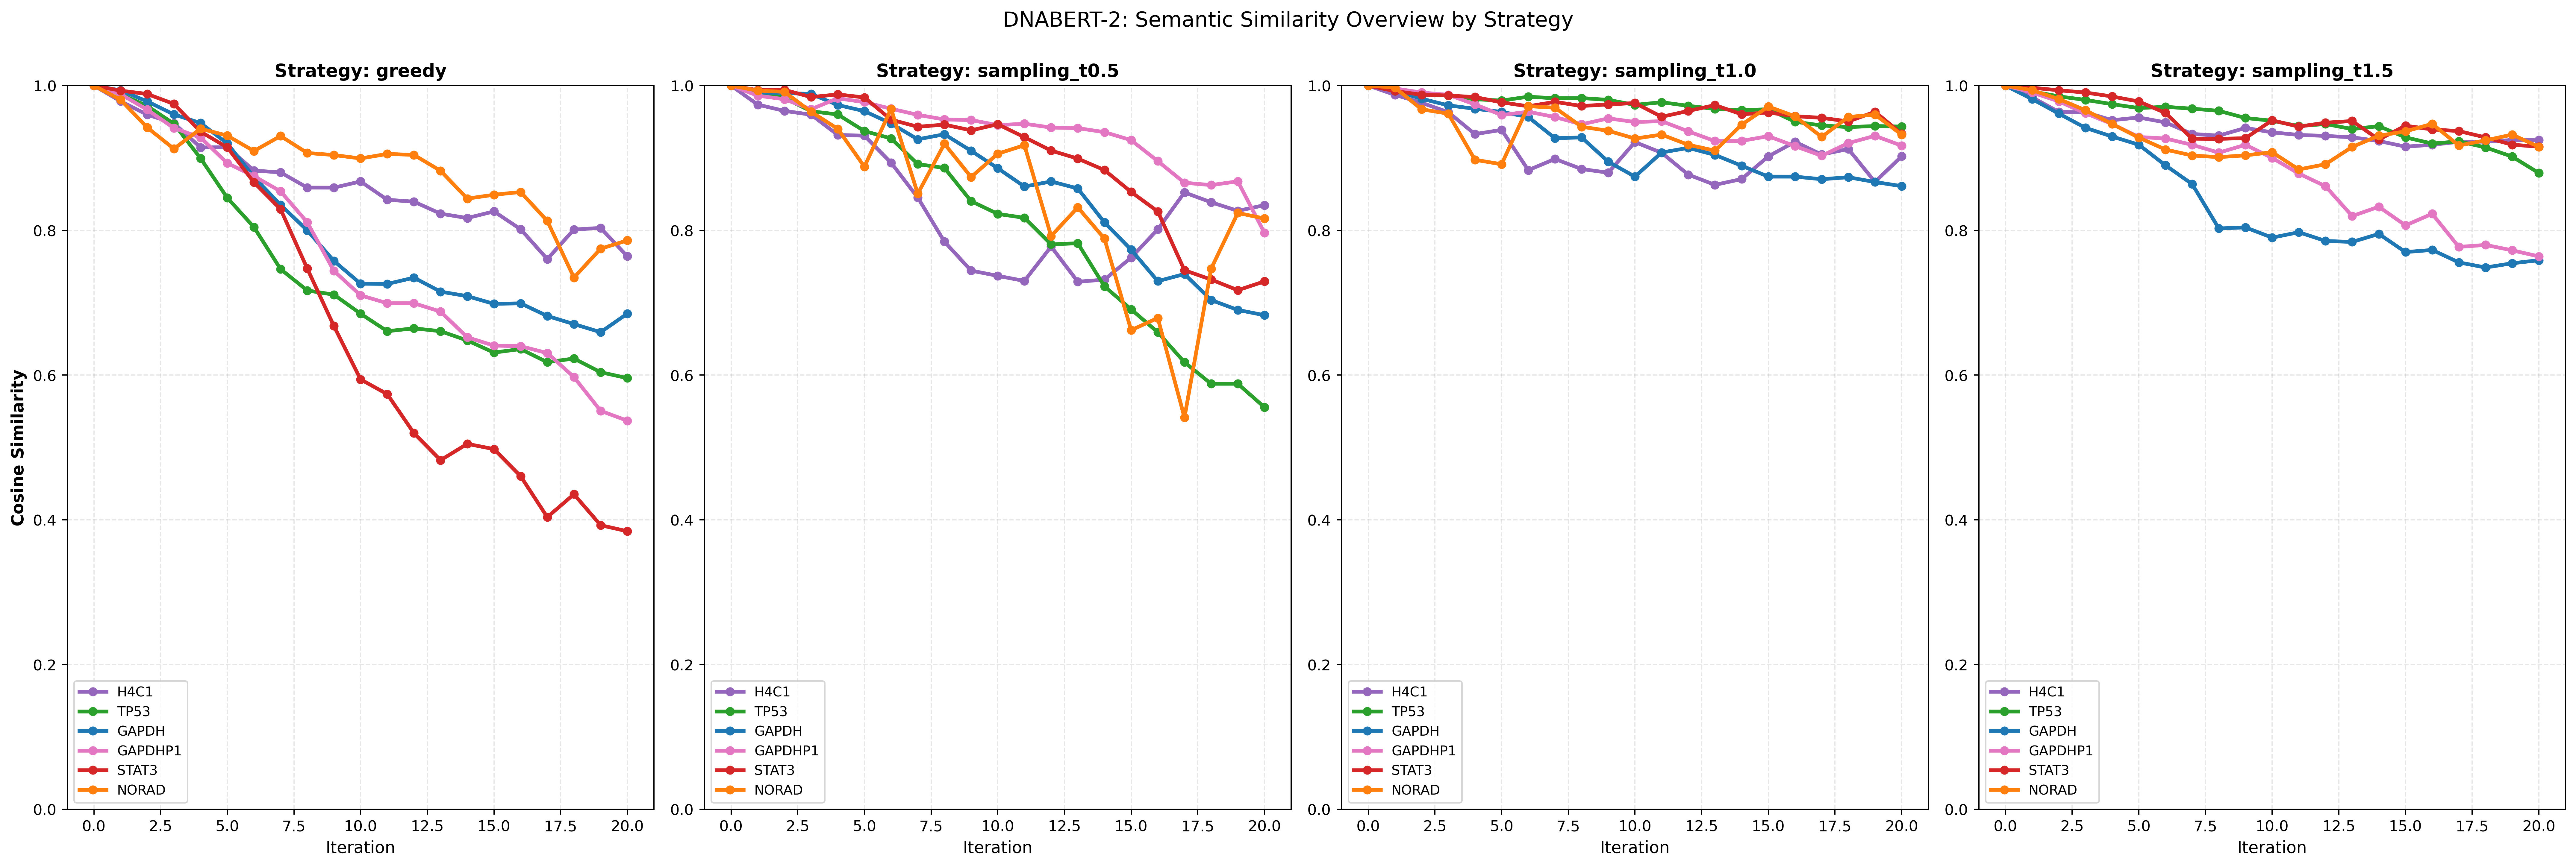

  ✓ 시각화 완료

NT-v2-50m:


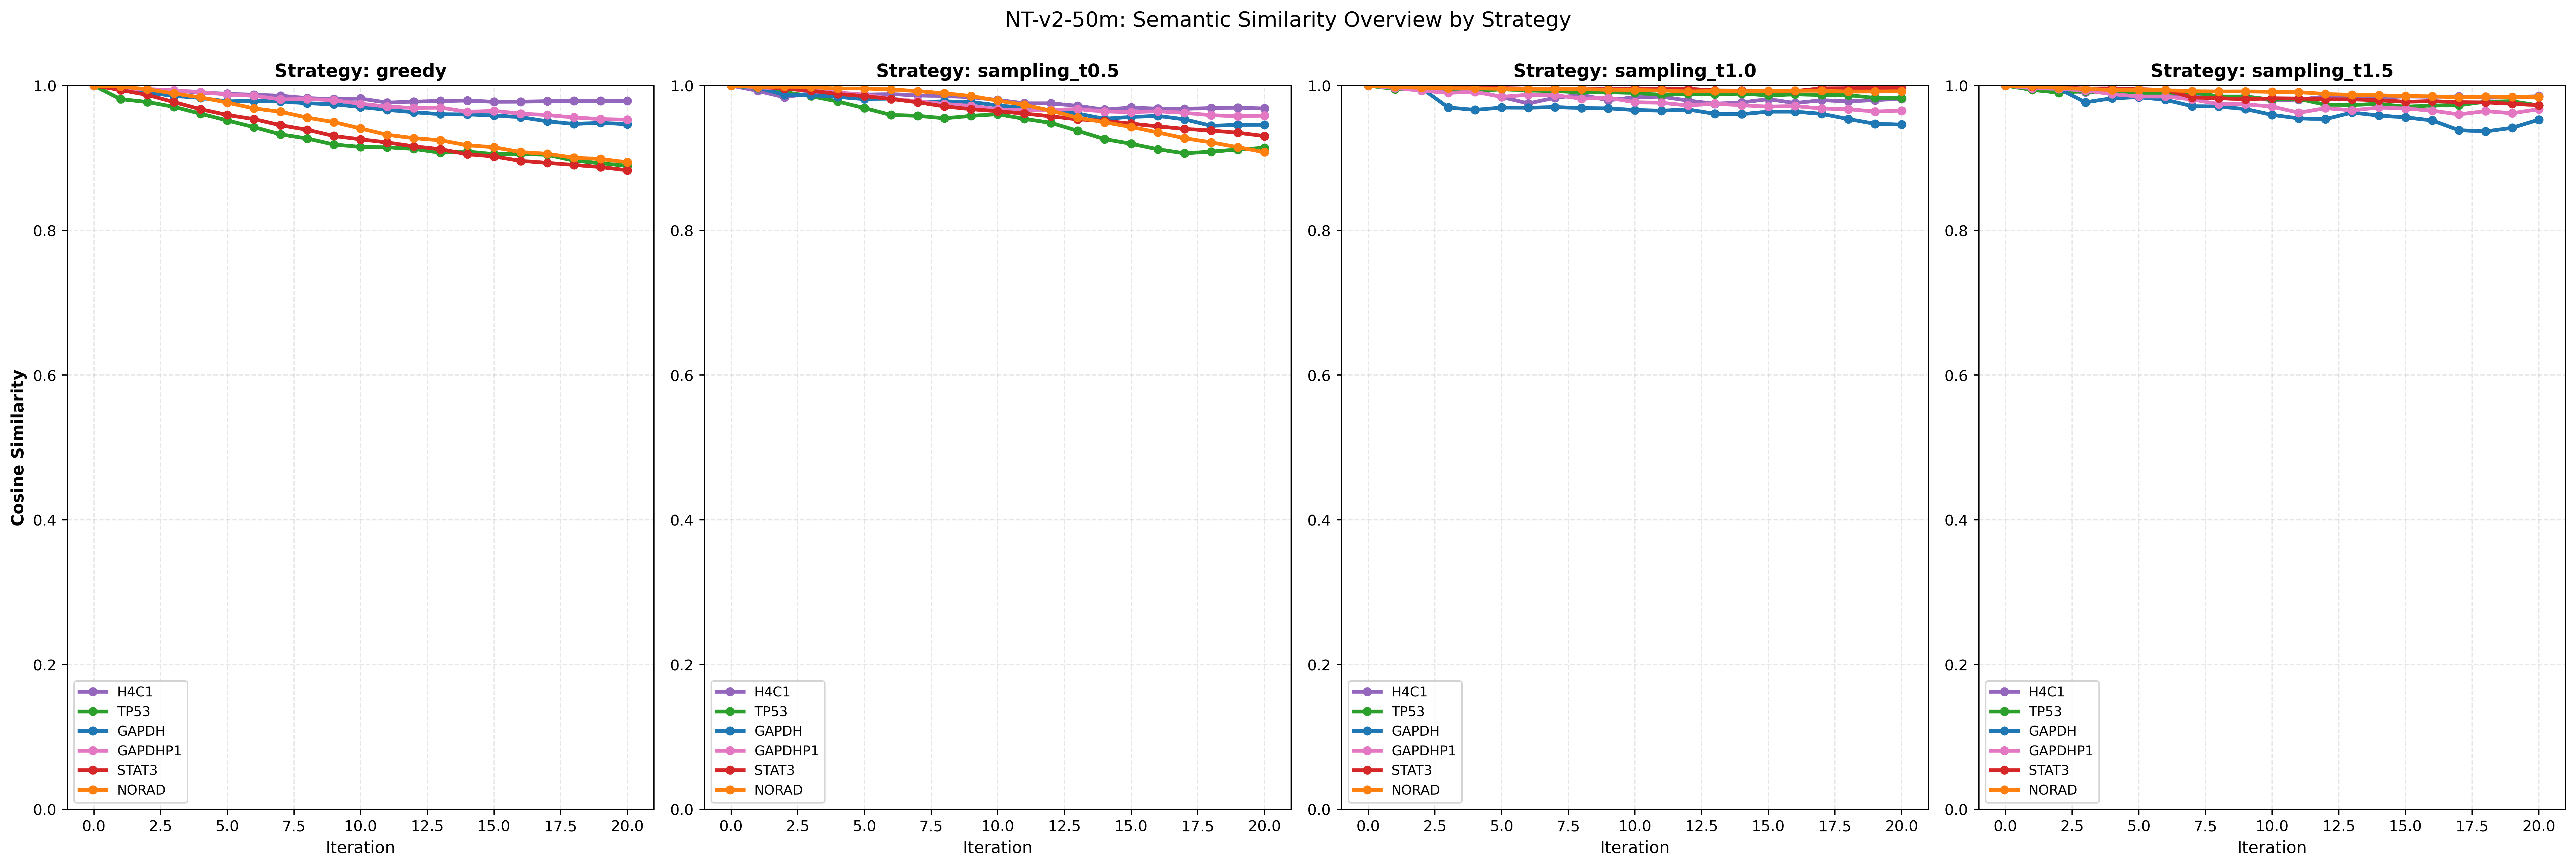

  ✓ 시각화 완료

NT-v2-500m:


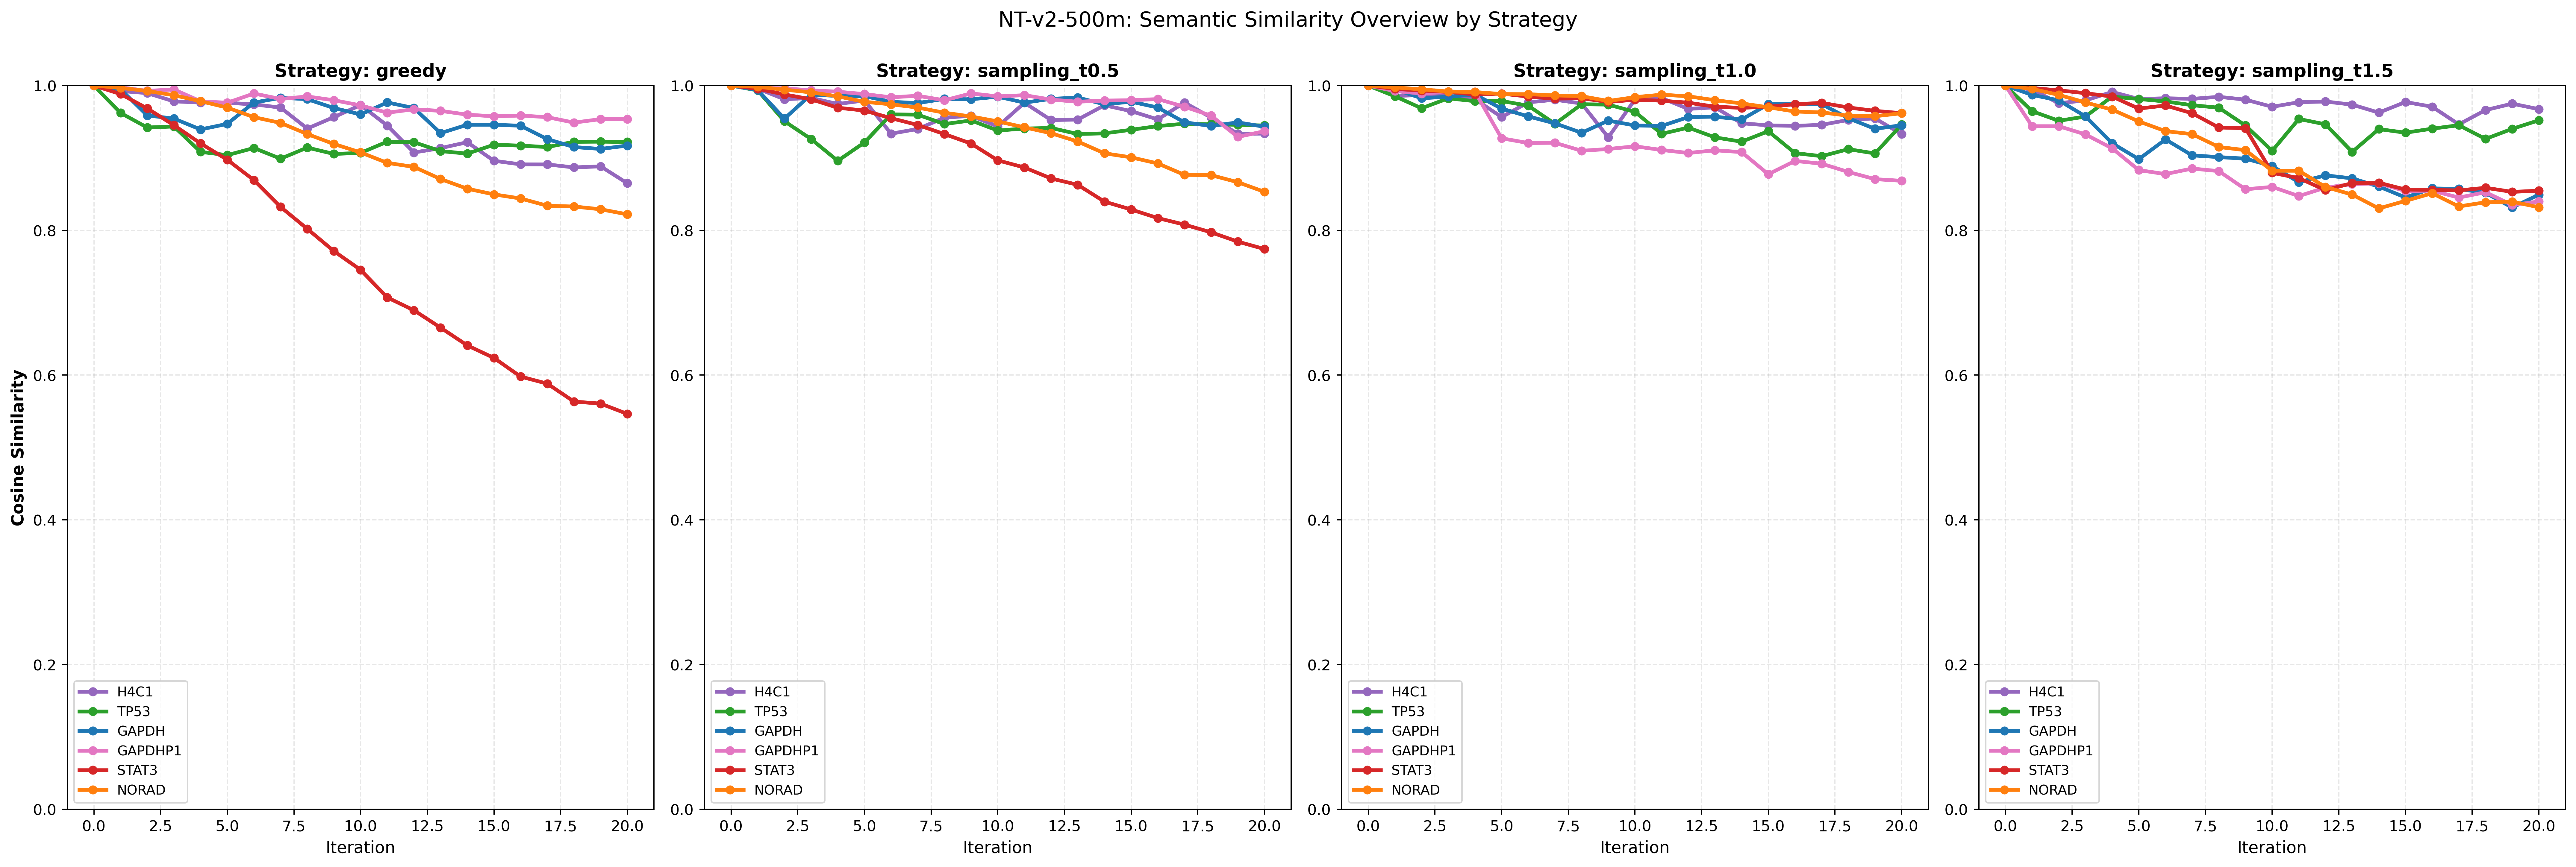

  ✓ 시각화 완료


In [5]:
# 각 모델의 의미적 유사도 시각화 (전체 gene overview - strategy별)
def plot_similarity_overview_by_strategy(embeddings_dict, model_name):
    """모델-strategy별 의미적 유사도 시각화 (모든 gene의 curve를 함께 표시)"""
    
    # 모든 gene과 strategy 수집
    all_genes = list(embeddings_dict.keys())
    preferred_gene_order = ['H4C1', 'TP53', 'GAPDH', 'GAPDHP1', 'STAT3', 'NORAD']
    all_genes = [g for g in preferred_gene_order if g in all_genes] + [g for g in all_genes if g not in preferred_gene_order]
    all_strategies = list(embeddings_dict[all_genes[0]].keys())
    
    num_strategies = len(all_strategies)
    num_cols = min(4, num_strategies)  # 한 줄에 최대 4개
    num_rows = 1
    
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 8), dpi=360)
    fig.suptitle(f"{model_name}: Semantic Similarity Overview by Strategy", fontsize=14, y=1.00)
    
    # axes를 1D로 변환 (편의상)
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)
    
    axes = axes.flatten()
    
    colors = {'STAT3': '#d62728', 'NORAD': '#ff7f0e', 'TP53': '#2ca02c', 
              'GAPDH': '#1f77b4', 'H4C1': '#9467bd', 'GAPDHP1': '#e377c2',
              'H4': '#8c564b'}
    
    for idx, strategy in enumerate(all_strategies):
        ax = axes[idx]
        
        for gene in all_genes:
            embeddings = embeddings_dict[gene].get(strategy, [])
            
            if not embeddings or len(embeddings) == 0:
                continue
            
            # 의미적 유사도 계산
            similarities = cosine_series_from_embeddings(embeddings)
            x = np.arange(len(similarities))
            
            gene_color = colors.get(gene, '#999999')
            ax.plot(x, similarities, marker='o', linestyle='-', 
                   color=gene_color, linewidth=2.5, markersize=5, label=gene)
        
        ax.set_xlabel('Iteration', fontsize=11)
        if idx % num_cols == 0:
            ax.set_ylabel('Cosine Similarity', fontsize=11, fontweight='bold')
        else:
            ax.set_ylabel('')
        ax.set_title(f"Strategy: {strategy}", fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            order = [labels.index(g) for g in preferred_gene_order if g in labels]
            order += [i for i, lbl in enumerate(labels) if lbl not in preferred_gene_order]
            ordered_handles = [handles[i] for i in order]
            ordered_labels = [labels[i] for i in order]
            ax.legend(ordered_handles, ordered_labels, loc='lower left', fontsize=9)
        else:
            ax.legend(loc='lower left', fontsize=9)
    
    # 초과 서브플롯 숨기기
    for idx in range(num_strategies, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 모든 모델에 대해 시각화 (strategy별)
for model_name in all_embeddings.keys():
    print(f"\n{model_name}:")
    plot_similarity_overview_by_strategy(all_embeddings[model_name], model_name)
    print(f"  ✓ 시각화 완료")

## Step 6: 유전자 카테고리 비교 (Coding vs Non-coding, Real vs Pseudogene)


DNABERT-2: Coding vs Non-coding (STAT3 vs NORAD)


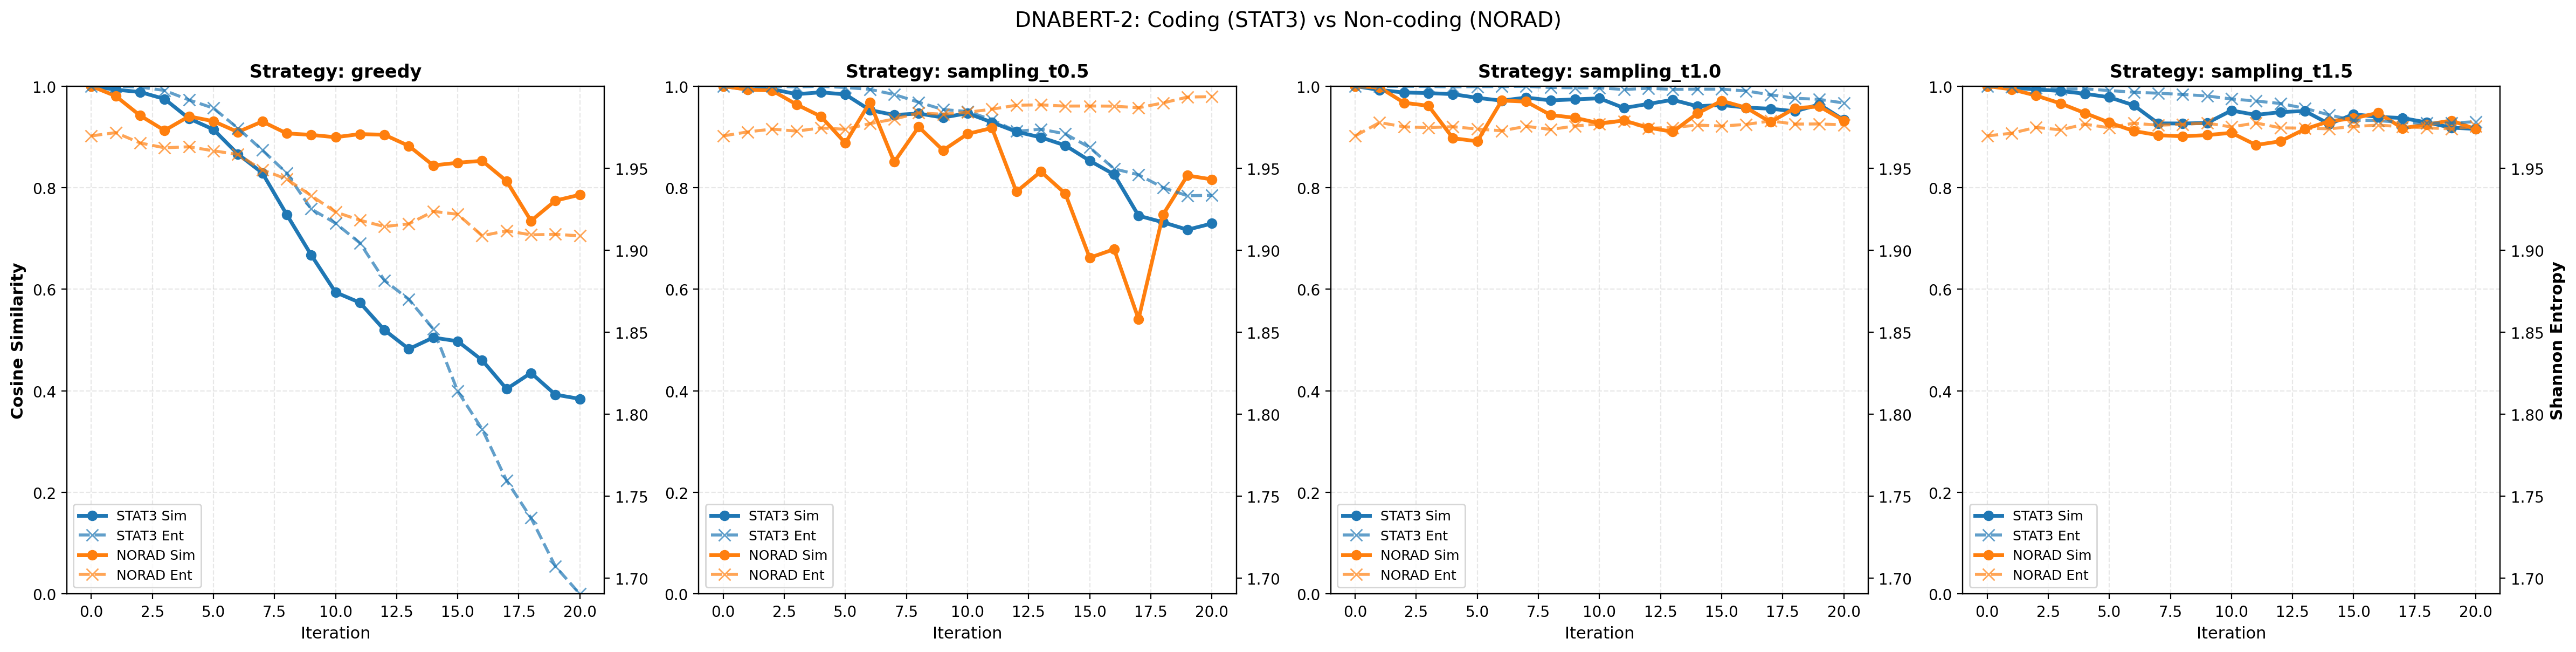

  ✓ 시각화 완료

NT-v2-50m: Coding vs Non-coding (STAT3 vs NORAD)


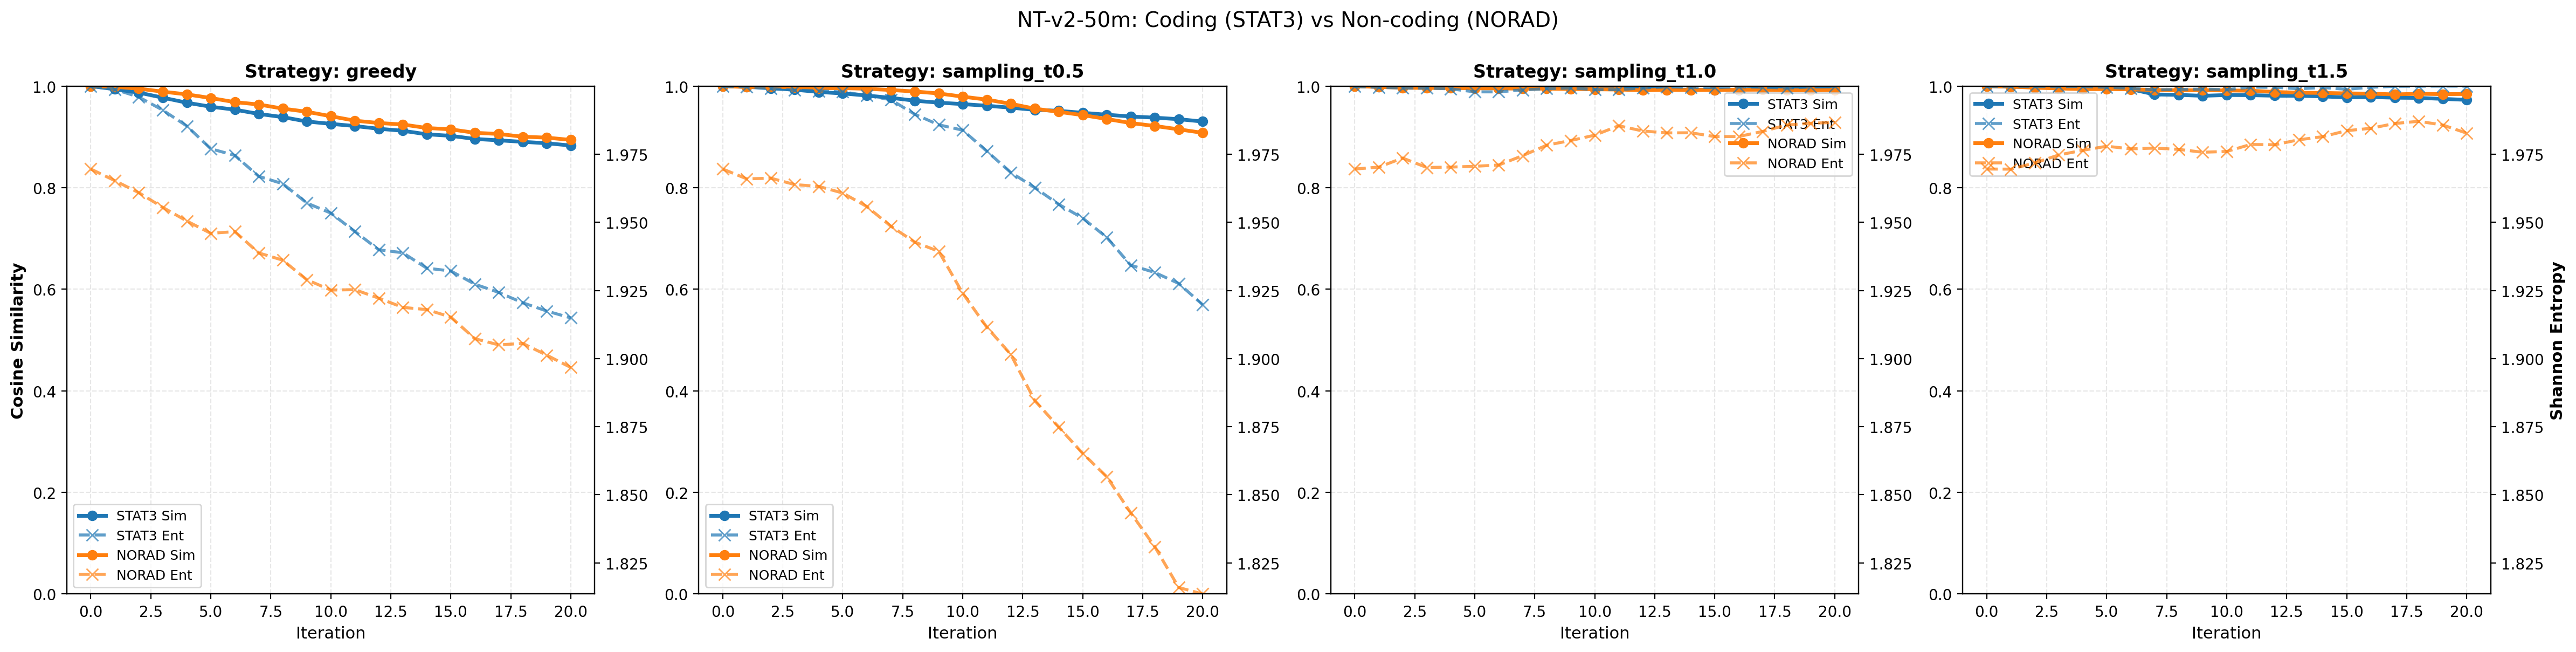

  ✓ 시각화 완료

NT-v2-500m: Coding vs Non-coding (STAT3 vs NORAD)


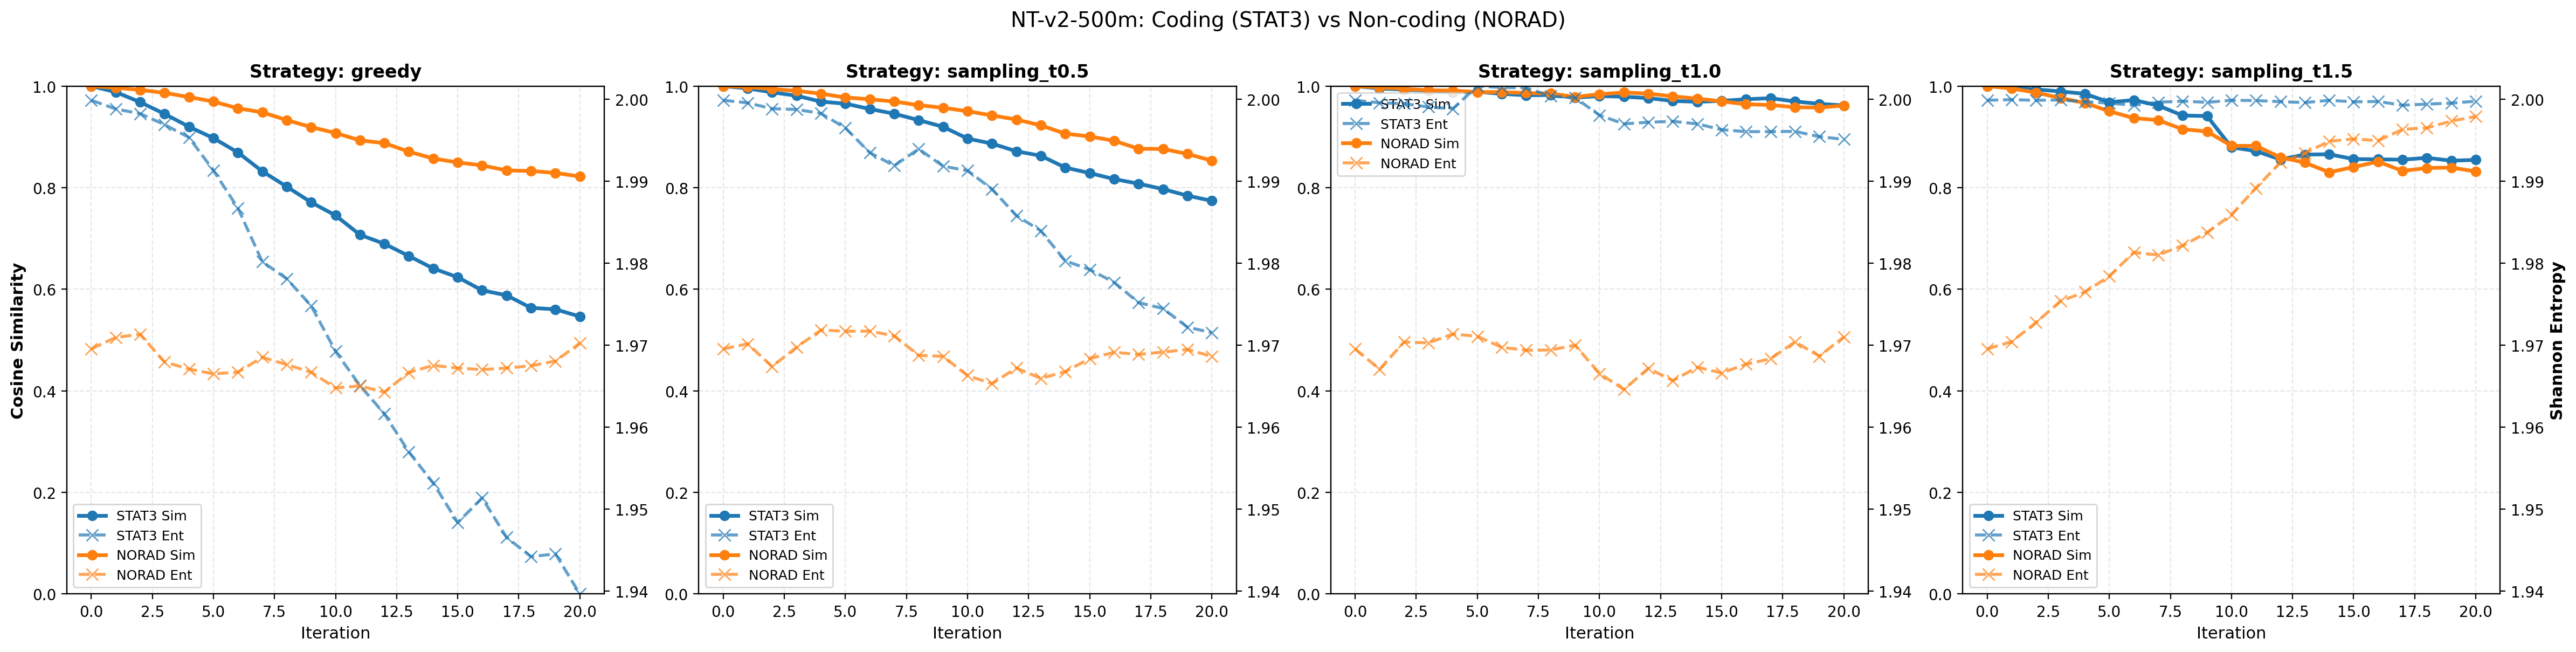

  ✓ 시각화 완료

DNABERT-2: Real vs Pseudogene (GAPDH vs GAPDHP1)


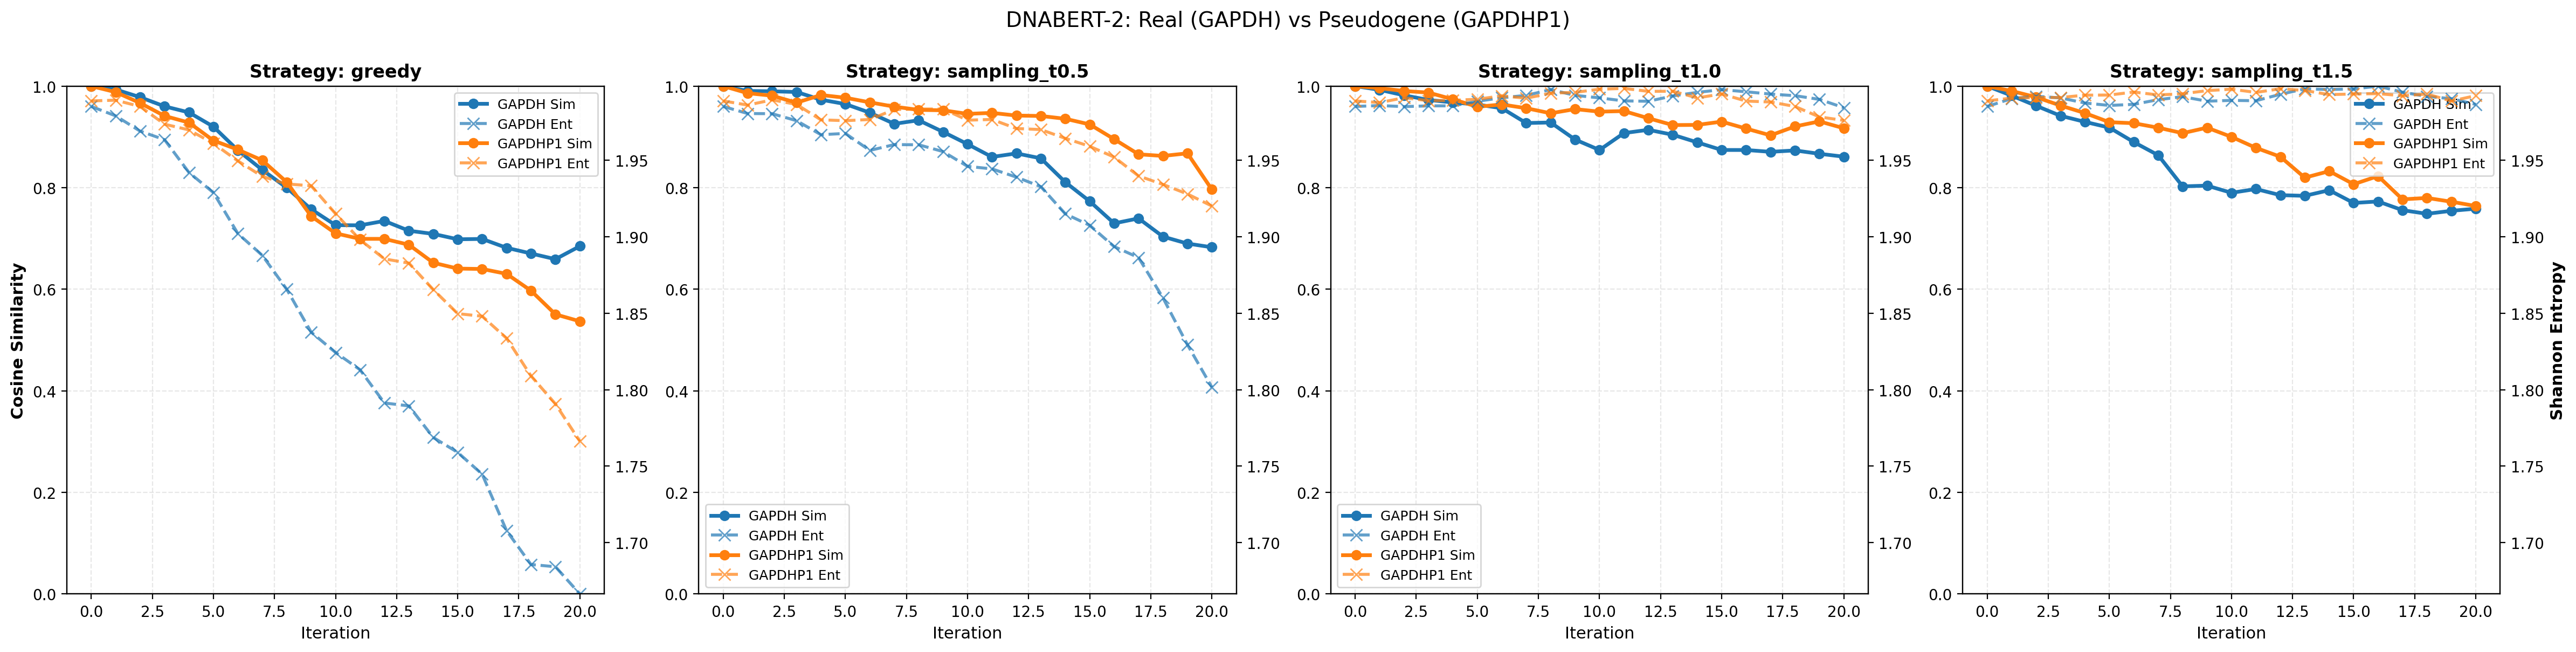

  ✓ 시각화 완료

NT-v2-50m: Real vs Pseudogene (GAPDH vs GAPDHP1)


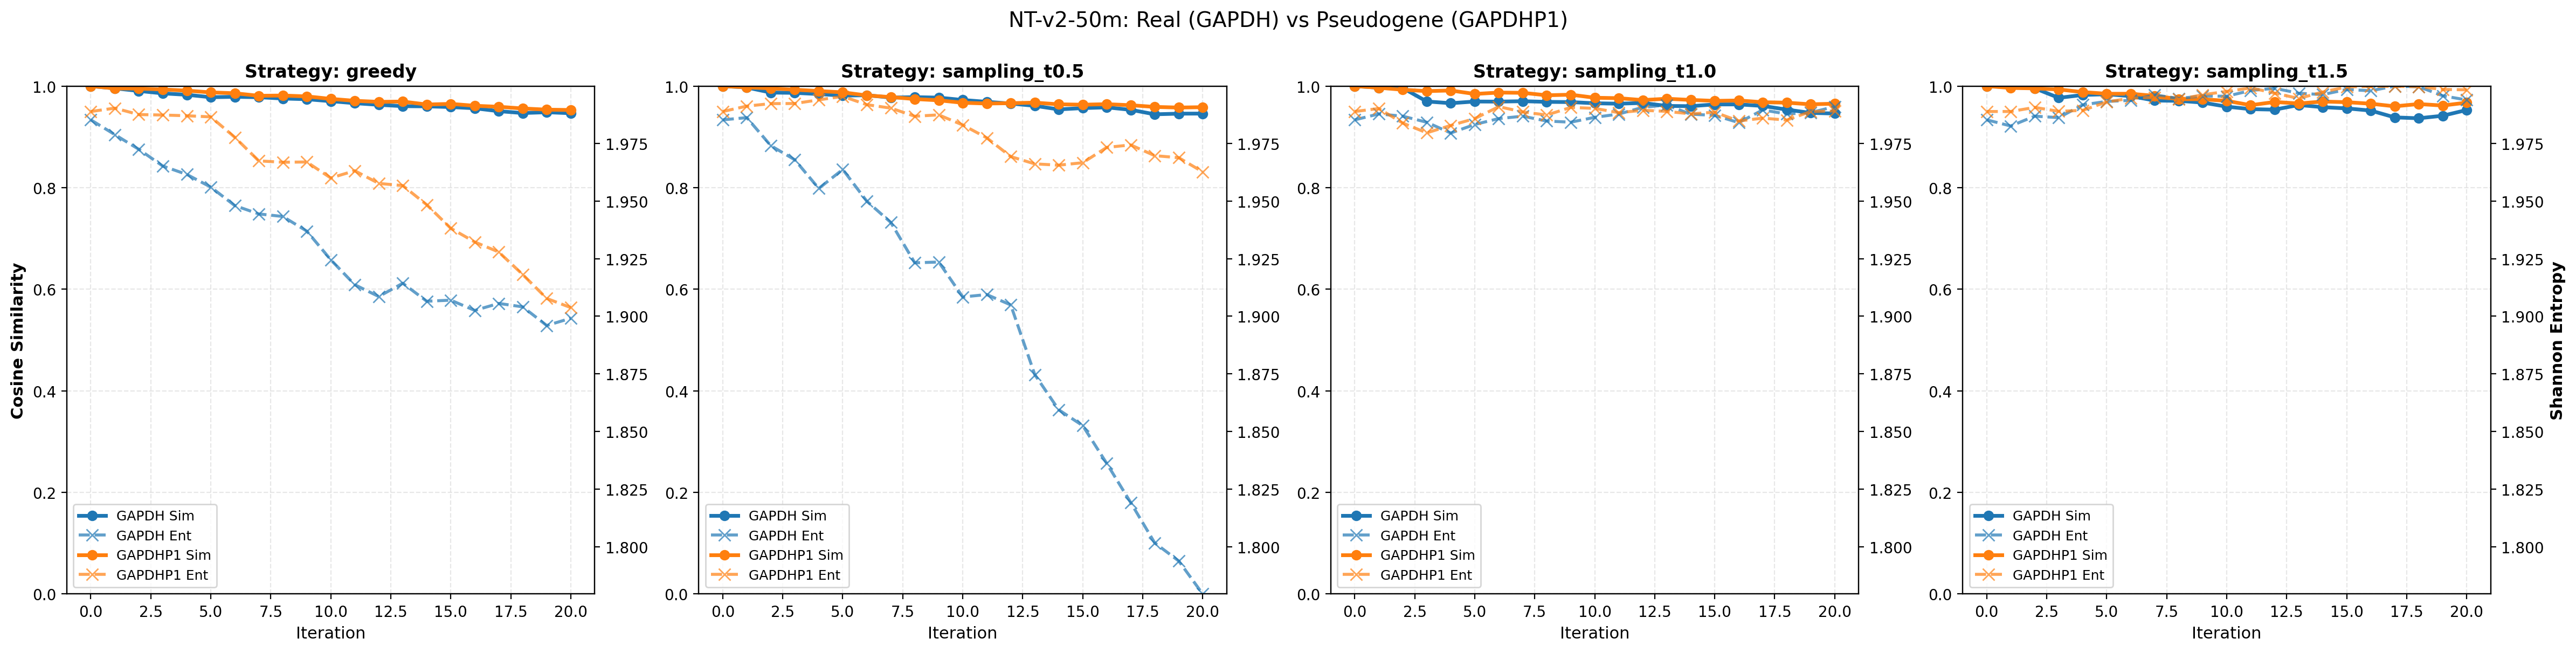

  ✓ 시각화 완료

NT-v2-500m: Real vs Pseudogene (GAPDH vs GAPDHP1)


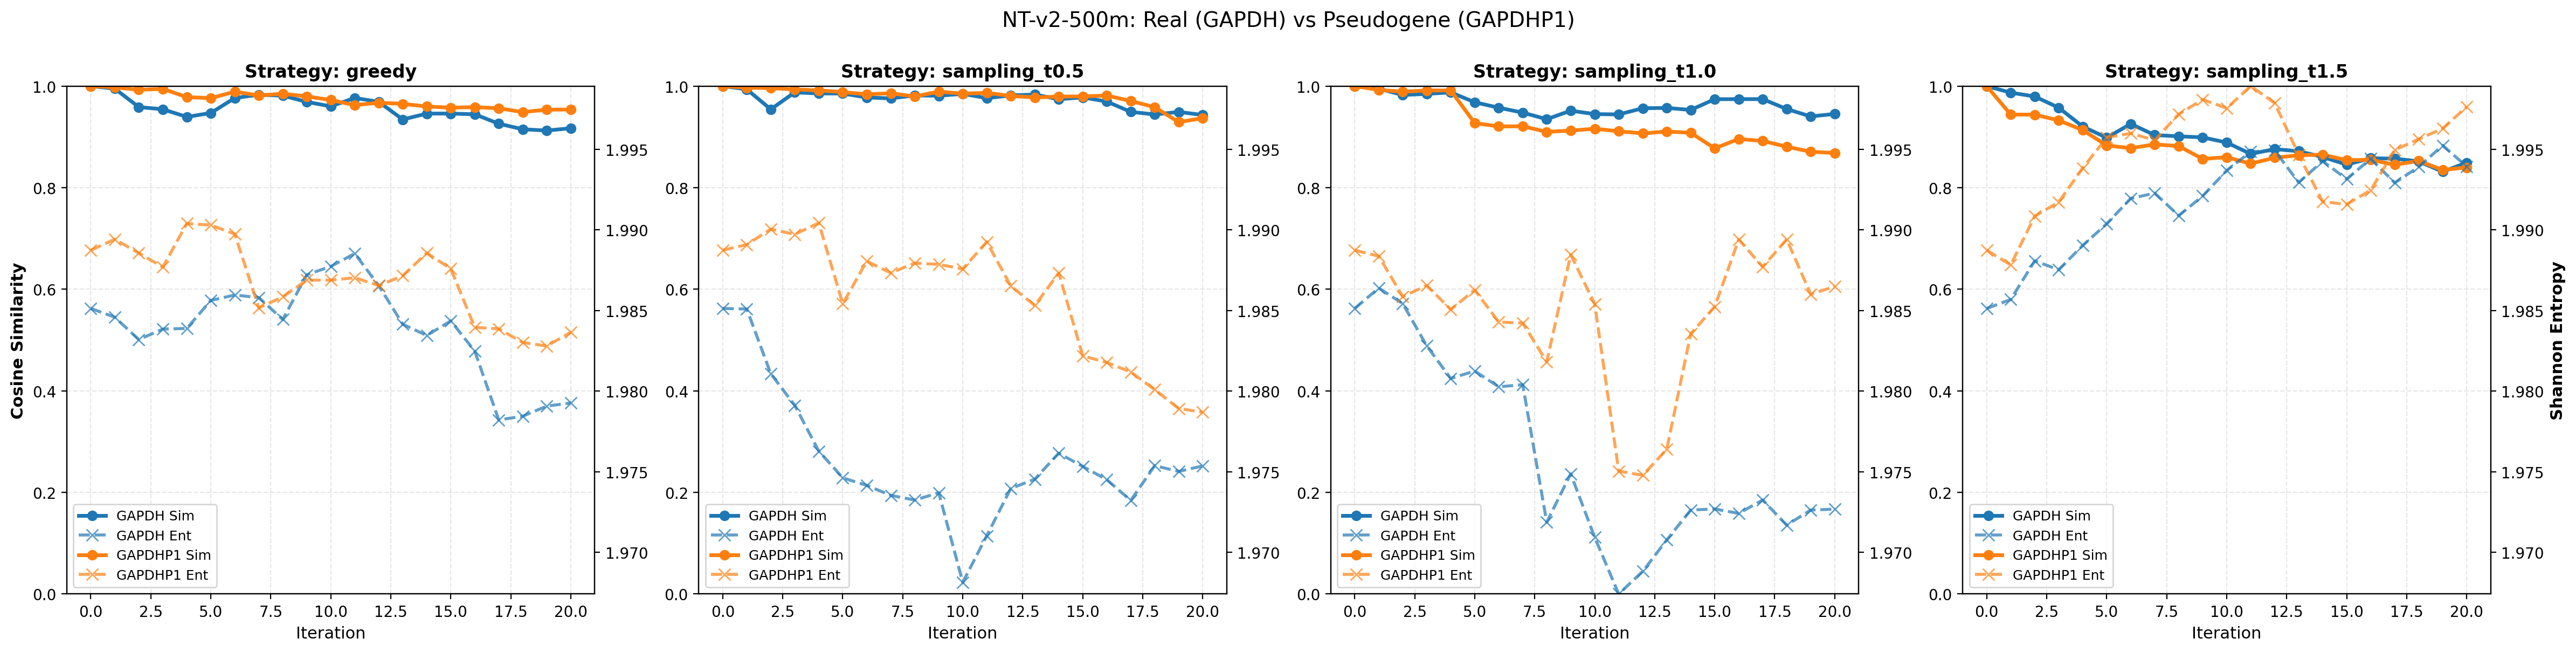

  ✓ 시각화 완료


In [12]:
# 두 유전자 쌍 비교 시각화
def plot_pairwise_gene_comparison(embeddings_dict, sequences_dict, model_name, gene_a, gene_b, title):
    """두 유전자 쌍 비교: Similarity (주축) + Entropy (보조축, 통일된 범위)"""
    
    if gene_a not in embeddings_dict or gene_b not in embeddings_dict:
        print(f"  ⚠️ {gene_a} 또는 {gene_b} 데이터 없음")
        return
    
    strategies = list(embeddings_dict[gene_a].keys())
    num_strategies = len(strategies)
    preferred_gene_order = ['H4C1', 'TP53', 'GAPDH', 'GAPDHP1', 'STAT3', 'NORAD']
    gene_order = [g for g in preferred_gene_order if g in [gene_a, gene_b]] + [g for g in [gene_a, gene_b] if g not in preferred_gene_order]
    num_cols = min(4, num_strategies)  # 한 줄에 최대 4개
    num_rows = 1
    
    # 모든 strategies의 entropy 범위를 미리 계산 (model + gene 별로 통일)
    global_entropies = []
    for strategy in strategies:
        for gene in gene_order:
            sequences = sequences_dict[gene].get(strategy, [])
            for seq in sequences:
                if isinstance(seq, str):
                    global_entropies.append(calculate_shannon_entropy(seq))
    
    global_entropy_min = min(global_entropies) if global_entropies else 0
    global_entropy_max = max(global_entropies) if global_entropies else 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6), dpi=200)
    fig.suptitle(f"{model_name}: {title}", fontsize=14, y=1.00)
    
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)
    
    axes = axes.flatten()
    
    colors = {gene_a: '#1f77b4', gene_b: '#ff7f0e'}
    
    for idx, strategy in enumerate(strategies):
        ax = axes[idx]
        ax2 = ax.twinx()
        
        # 각 유전자의 데이터 플롯
        for gene in gene_order:
            embeddings = embeddings_dict[gene].get(strategy, [])
            sequences = sequences_dict[gene].get(strategy, [])
            
            if not embeddings:
                continue
            
            # 주축: Semantic Similarity
            similarities = cosine_series_from_embeddings(embeddings)
            x = np.arange(len(similarities))
            
            gene_color = colors.get(gene, '#999999')
            ax.plot(x, similarities, marker='o', linestyle='-', 
                   color=gene_color, linewidth=2.5, markersize=6, label=f'{gene} Sim')
            
            # 보조축: Shannon Entropy
            entropies = [calculate_shannon_entropy(seq) if isinstance(seq, str) else 0 for seq in sequences]
            ax2.plot(x, entropies, marker='x', linestyle='--', 
                    color=gene_color, linewidth=2, alpha=0.7, markersize=8, label=f'{gene} Ent')
        
        # 주축 설정
        ax.set_xlabel('Iteration', fontsize=11)
        if idx % num_cols == 0:
            ax.set_ylabel('Cosine Similarity', color='black', fontsize=11, fontweight='bold')
        else:
            ax.set_ylabel('')
        ax.set_ylim(0, 1)
        ax.tick_params(axis='y', labelcolor='black')
        
        # 보조축 설정 (model + gene 별로 통일된 범위)
        if idx % num_cols == num_cols-1:
            ax2.set_ylabel('Shannon Entropy', color='black', fontsize=11, fontweight='bold')
        else:
            ax2.set_ylabel('')
        ax2.set_ylim(global_entropy_min, global_entropy_max)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax.set_title(f"Strategy: {strategy}", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # 범례 통합
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        combined_handles = lines1 + lines2
        combined_labels = labels1 + labels2
        if combined_handles:
            def _legend_key(lbl):
                parts = lbl.split(' ')
                gene = parts[0] if parts else lbl
                kind = parts[1] if len(parts) > 1 else ''
                gene_order_idx = preferred_gene_order.index(gene) if gene in preferred_gene_order else len(preferred_gene_order)
                kind_order = 0 if kind == 'Sim' else 1
                return (gene_order_idx, kind_order)
            order = sorted(range(len(combined_labels)), key=lambda i: _legend_key(combined_labels[i]))
            ordered_handles = [combined_handles[i] for i in order]
            ordered_labels = [combined_labels[i] for i in order]
            ax.legend(ordered_handles, ordered_labels, loc='best', fontsize=9)
        else:
            ax.legend(loc='best', fontsize=9)
    
    # 초과 서브플롯 숨기기
    for idx in range(num_strategies, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# STAT3 vs NORAD 비교
for model_name in all_embeddings.keys():
    print(f"\n{model_name}: Coding vs Non-coding (STAT3 vs NORAD)")
    if 'STAT3' in all_embeddings[model_name] and 'NORAD' in all_embeddings[model_name]:
        plot_pairwise_gene_comparison(
            all_embeddings[model_name],
            all_sequences[model_name],
            model_name,
            'STAT3',
            'NORAD',
            'Coding (STAT3) vs Non-coding (NORAD)'
        )
        print(f"  ✓ 시각화 완료")
    else:
        print(f"  ⚠️ 데이터 부족")

# GAPDH vs GAPDHP1 비교
for model_name in all_embeddings.keys():
    print(f"\n{model_name}: Real vs Pseudogene (GAPDH vs GAPDHP1)")
    if 'GAPDH' in all_embeddings[model_name] and 'GAPDHP1' in all_embeddings[model_name]:
        plot_pairwise_gene_comparison(
            all_embeddings[model_name],
            all_sequences[model_name],
            model_name,
            'GAPDH',
            'GAPDHP1',
            'Real (GAPDH) vs Pseudogene (GAPDHP1)'
        )
        print(f"  ✓ 시각화 완료")
    else:
        print(f"  ⚠️ 데이터 부족")

## Step 7: Cross-Validation (DNABERT-2 vs NT)

In [9]:
# Cross-validation: 한 모델이 다른 모델의 시퀀스를 평가

def cross_evaluate_sequences(source_sequences, source_model_name, target_model_instance, target_model_name):
    """한 모델이 다른 모델의 시퀀스를 평가"""
    
    cross_eval = {}  # {gene_id: {strategy: [cosine_similarities]}}
    
    for gene_id, strategies in source_sequences.items():
        cross_eval[gene_id] = {}
        
        for strategy, sequences in strategies.items():
            if not sequences or len(sequences) == 0:
                continue
            
            # 시퀀스를 target model로 임베딩
            embeddings = []
            for seq in sequences:
                if pd.isna(seq) or seq == "":
                    continue
                try:
                    emb = target_model_instance.get_embedding(str(seq))
                    embeddings.append(emb)
                except Exception as e:
                    pass
            
            if embeddings:
                similarities = cosine_series_from_embeddings(embeddings)
                cross_eval[gene_id][strategy] = similarities
            
            gc.collect()
            if device == "cuda":
                torch.cuda.empty_cache()
            elif device == "mps":
                torch.mps.empty_cache()
    
    return cross_eval

print("Cross-validation 계산 중...")

# 모든 모델 조합에 대해 cross-validation
model_names = list(models.keys())
cross_validations = {}

for i, source_model in enumerate(model_names):
    source_model_name = source_model.replace("/", "-")
    for j, target_model in enumerate(model_names):
        if i == j:
            continue
        
        target_model_name = target_model.replace("/", "-")
        key = f"{source_model_name}_eval_by_{target_model_name}"
        
        print(f"\n계산 중: {source_model_name} sequences → {target_model_name} evaluation")
        
        cross_eval = cross_evaluate_sequences(
            all_sequences[source_model_name],
            source_model_name,
            models[target_model],
            target_model_name
        )
        
        cross_validations[key] = cross_eval
        print(f"  ✓ 완료")

print(f"\n✅ Cross-validation 계산 완료")

Cross-validation 계산 중...

계산 중: DNABERT-2 sequences → NT-v2-50m evaluation
  ✓ 완료

계산 중: DNABERT-2 sequences → NT-v2-500m evaluation
  ✓ 완료

계산 중: NT-v2-50m sequences → DNABERT-2 evaluation
  ✓ 완료

계산 중: NT-v2-50m sequences → NT-v2-500m evaluation
  ✓ 완료

계산 중: NT-v2-500m sequences → DNABERT-2 evaluation
  ✓ 완료

계산 중: NT-v2-500m sequences → NT-v2-50m evaluation
  ✓ 완료

✅ Cross-validation 계산 완료


## Step 8: Cross-Validation 시각화


시각화: DNABERT-2_eval_by_NT-v2-50m


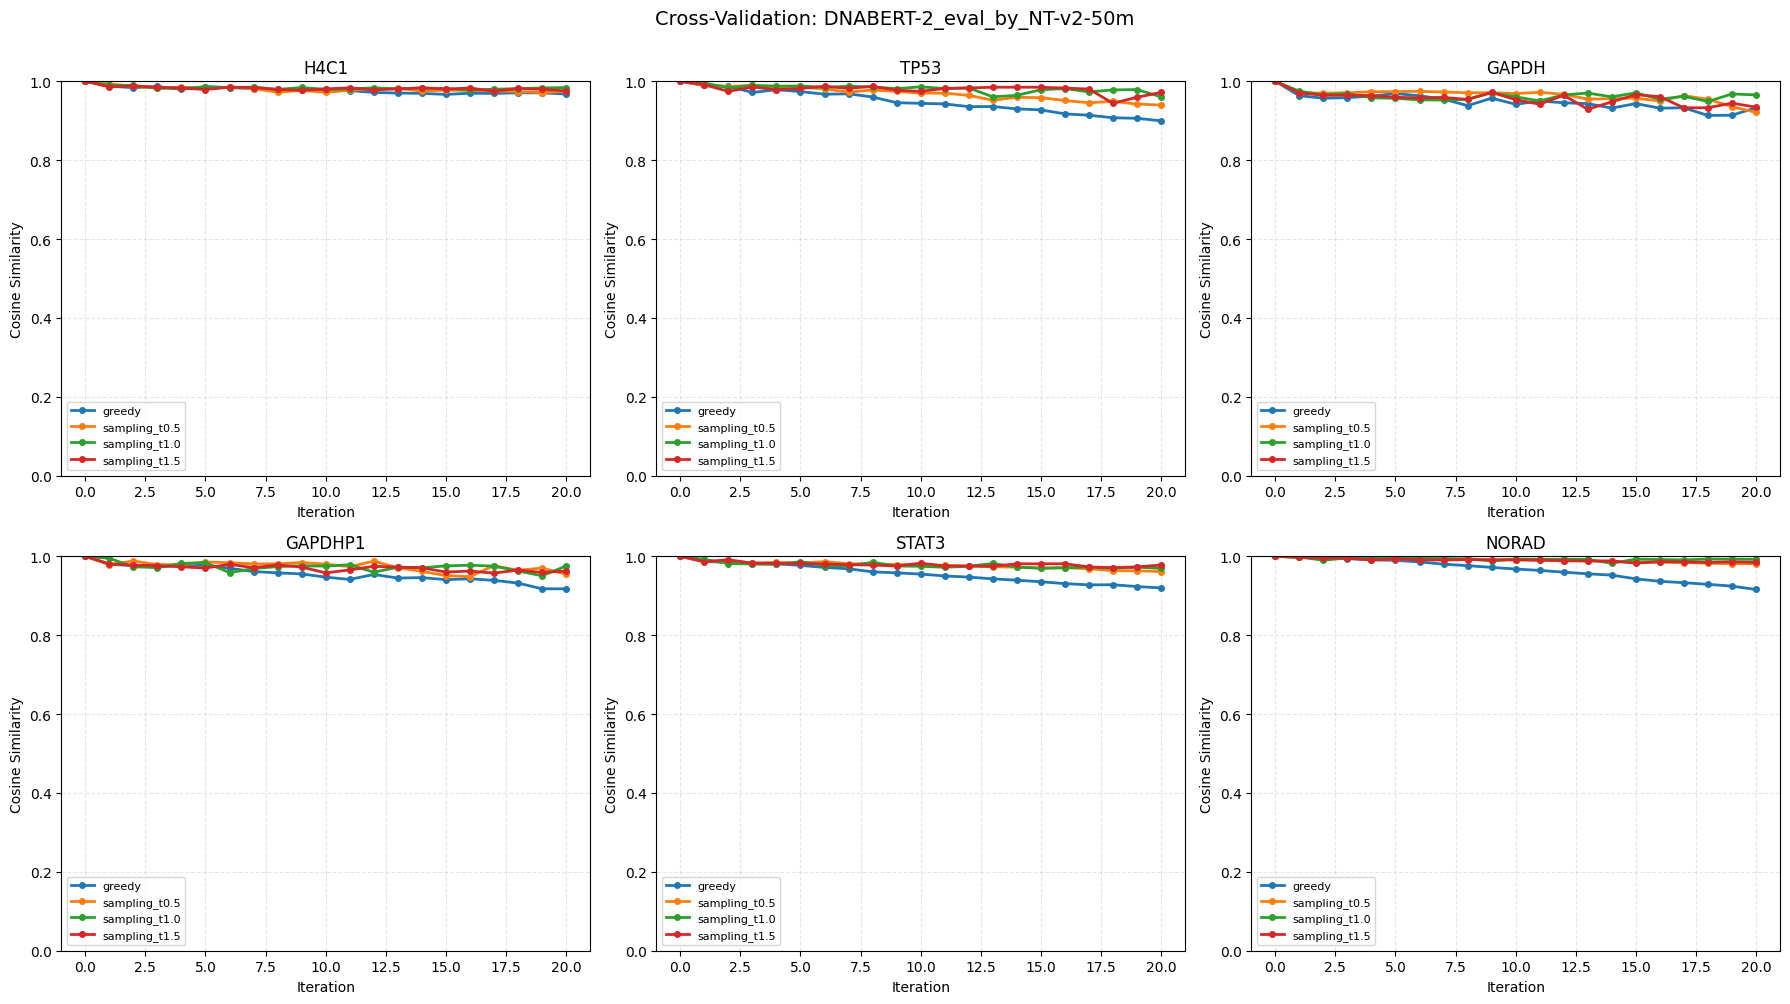

  ✓ 완료

시각화: DNABERT-2_eval_by_NT-v2-500m


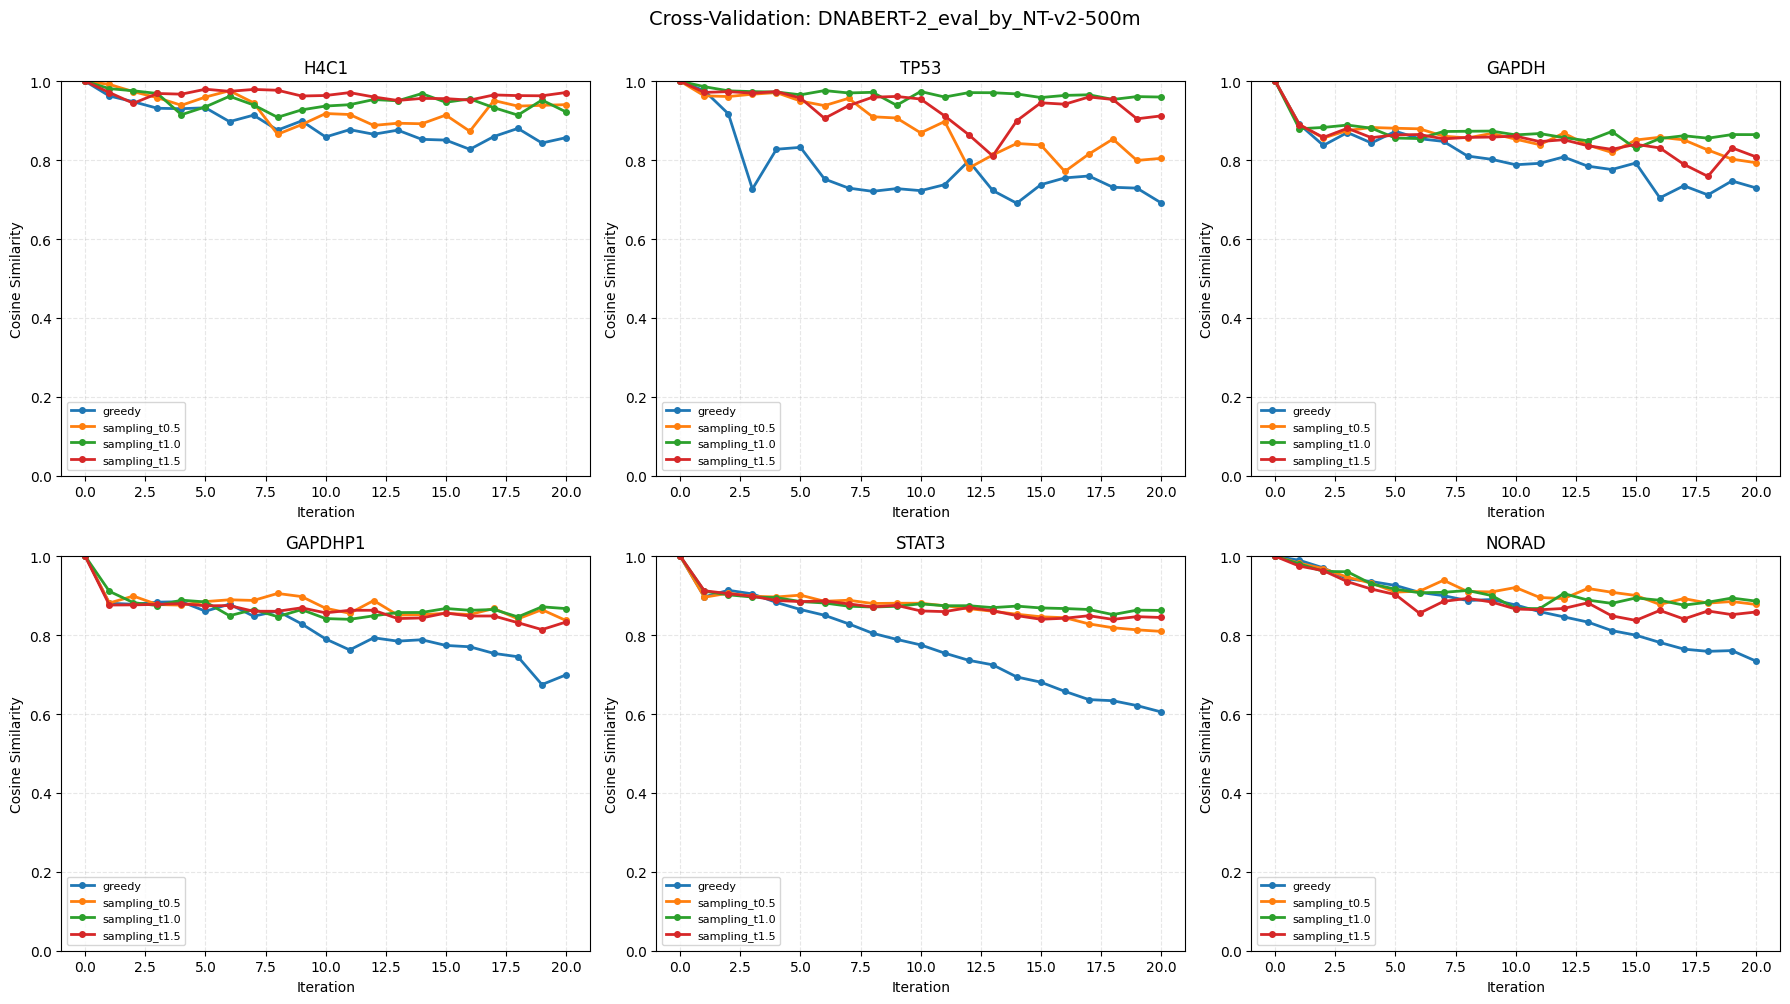

  ✓ 완료

시각화: NT-v2-50m_eval_by_DNABERT-2


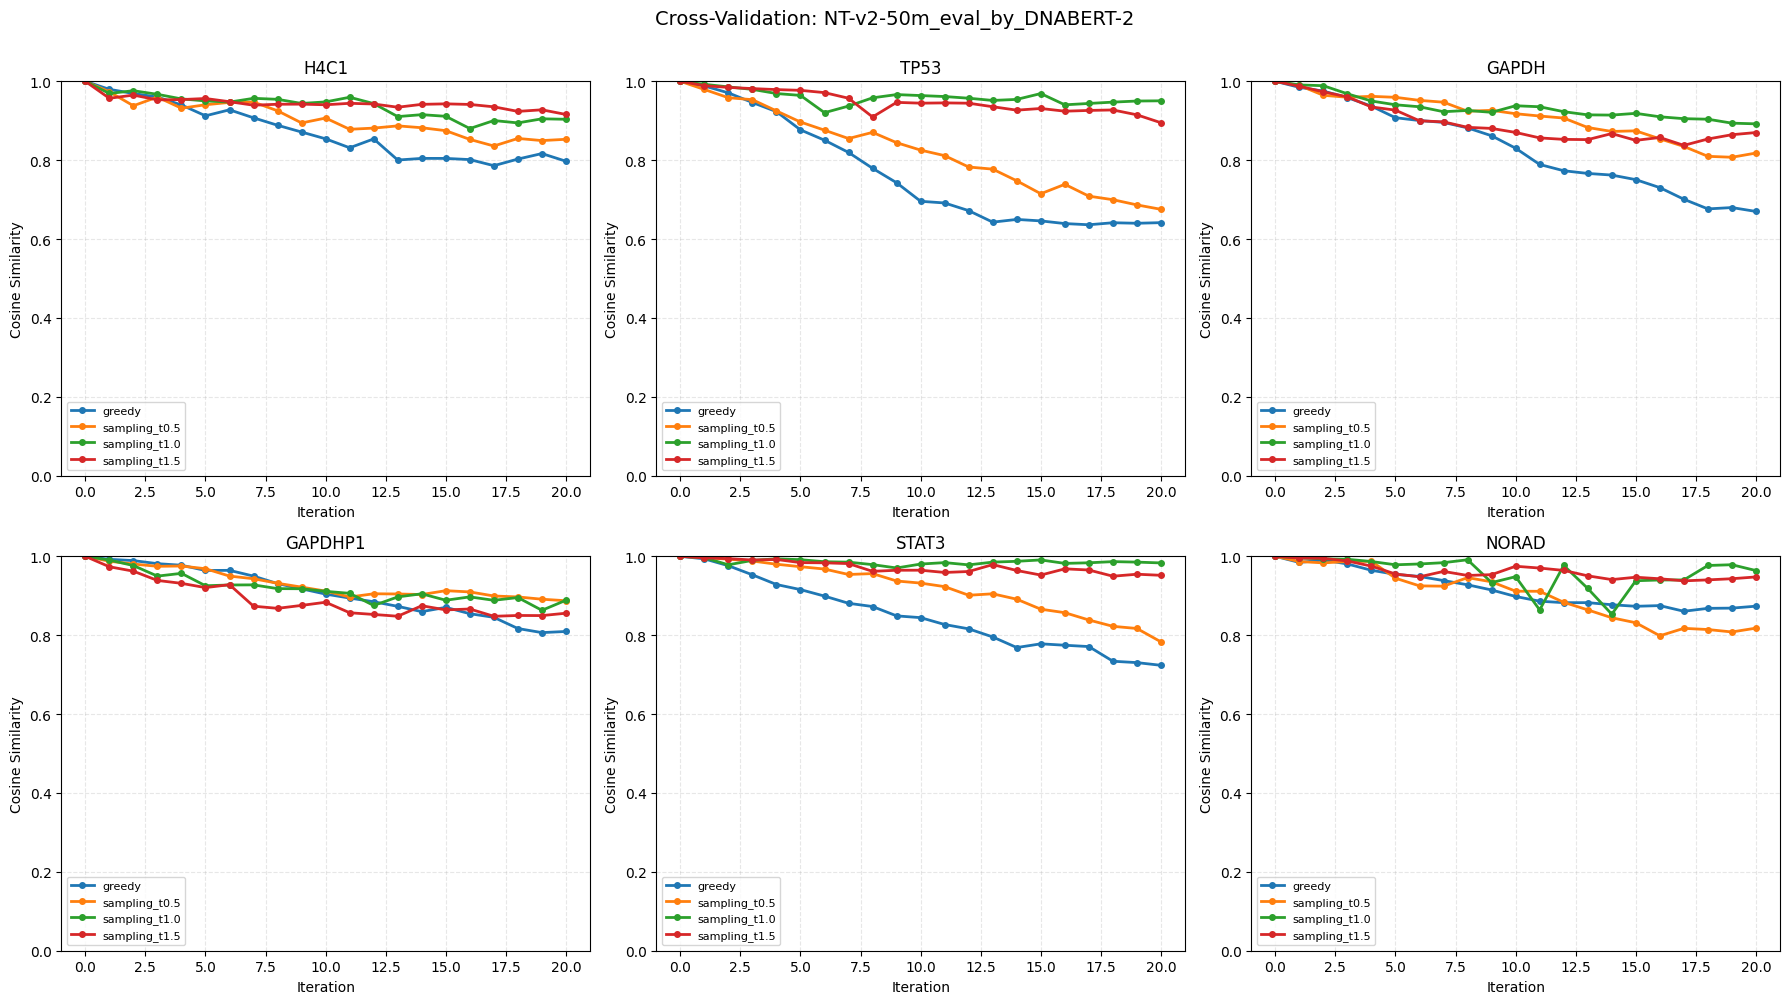

  ✓ 완료

시각화: NT-v2-50m_eval_by_NT-v2-500m


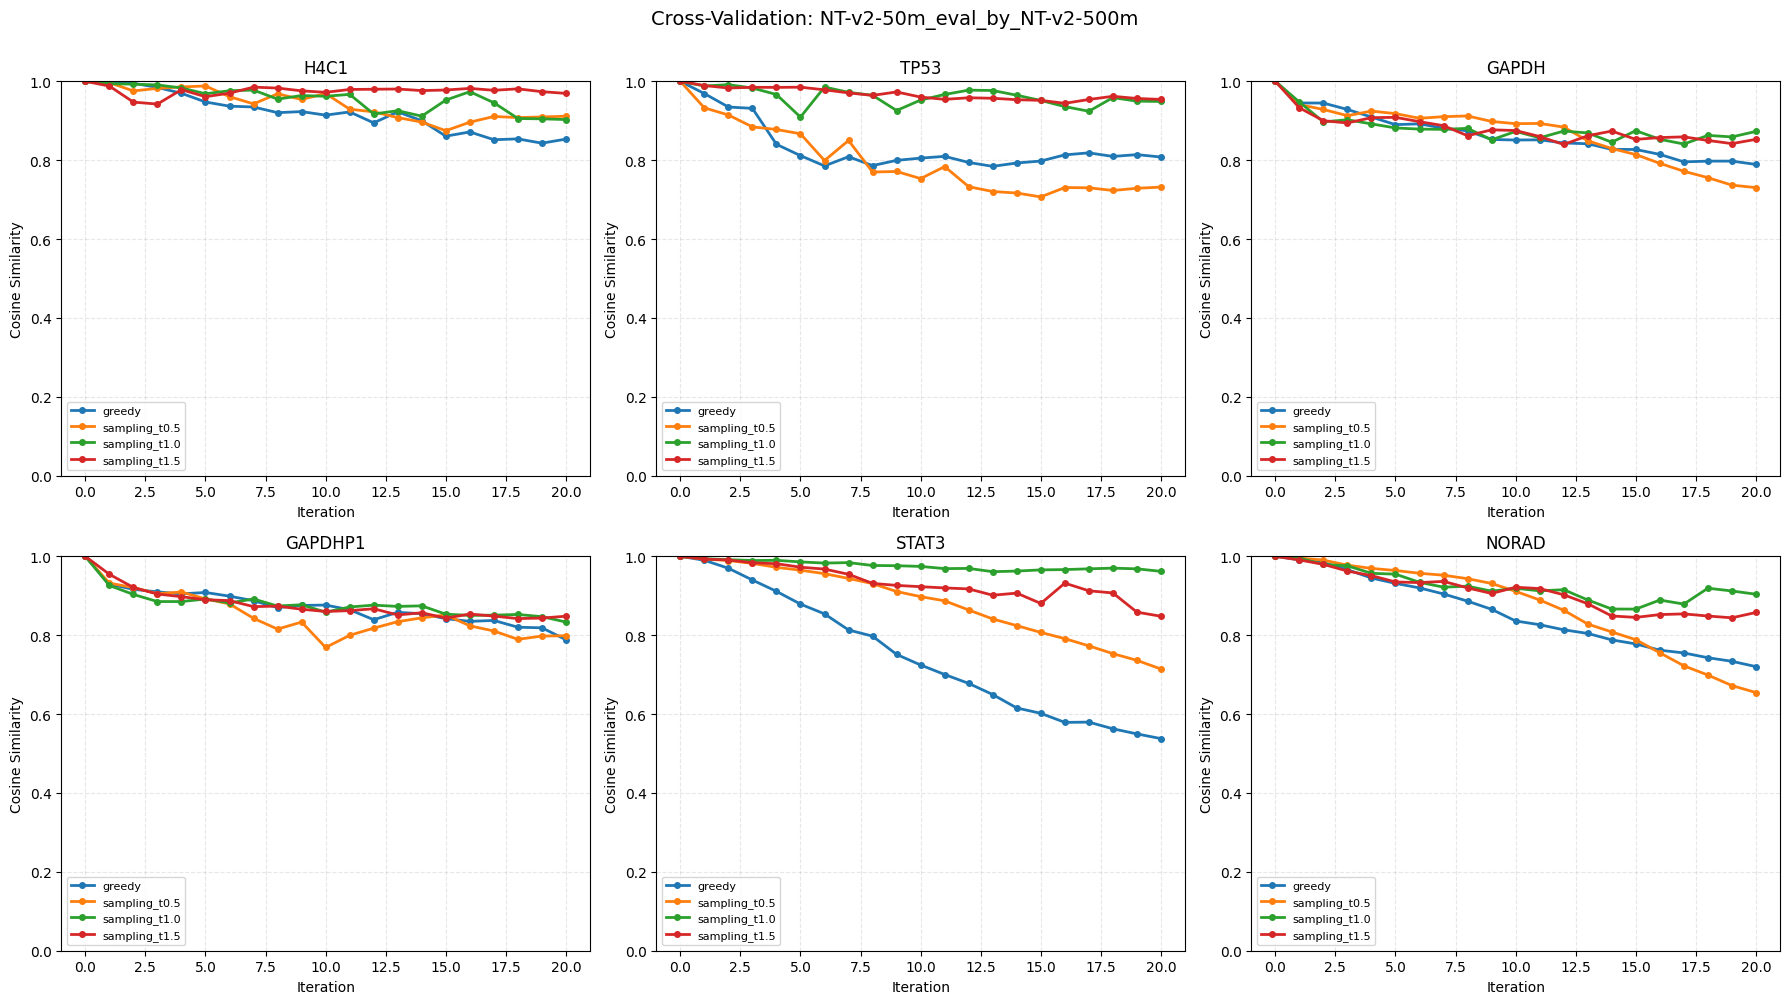

  ✓ 완료

시각화: NT-v2-500m_eval_by_DNABERT-2


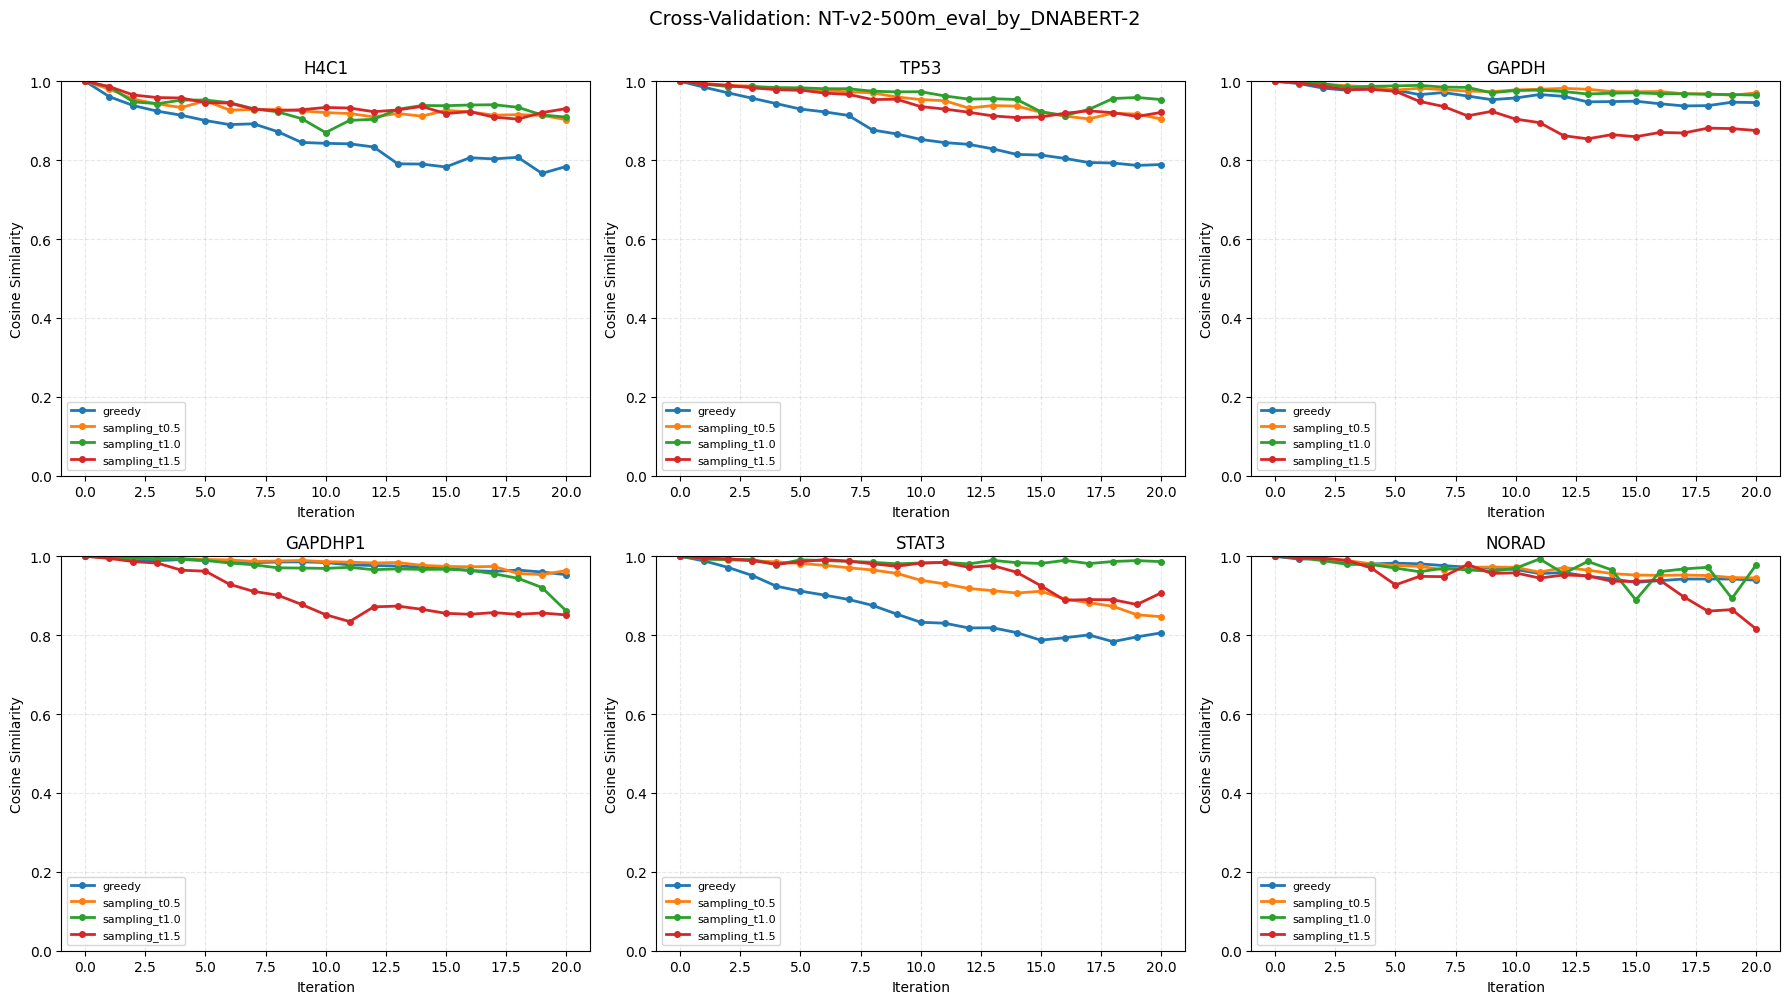

  ✓ 완료

시각화: NT-v2-500m_eval_by_NT-v2-50m


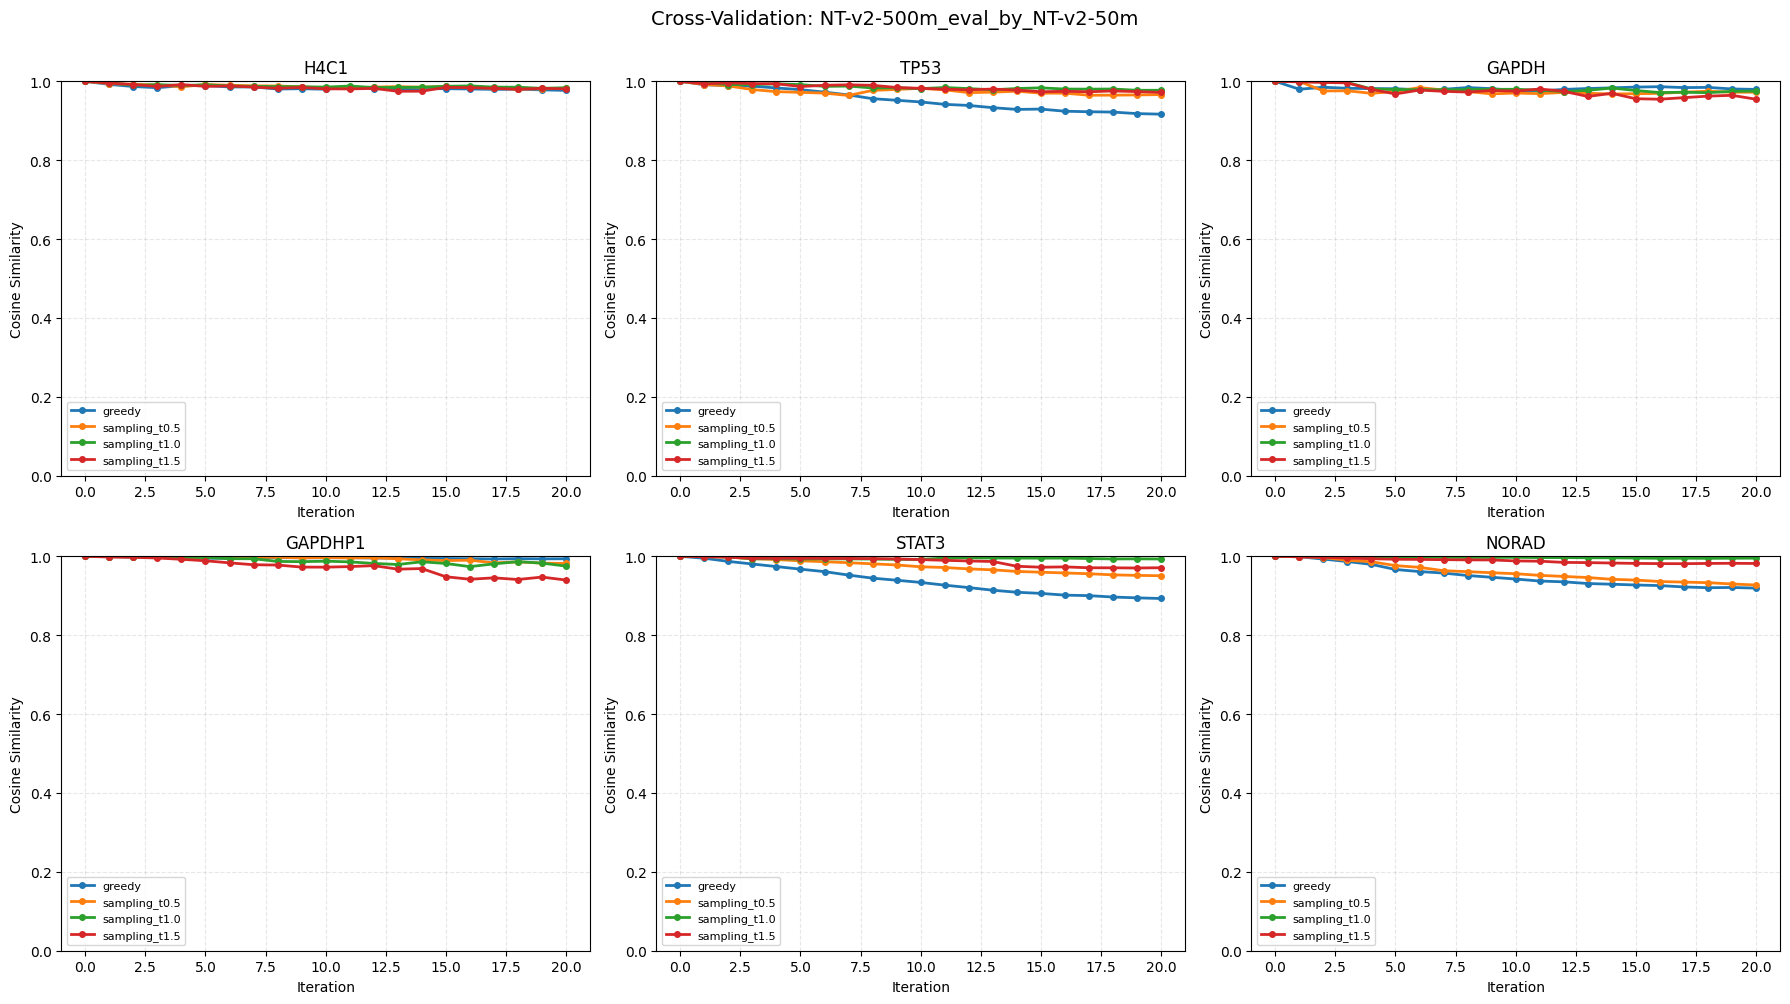

  ✓ 완료


In [10]:
def plot_cross_validation(cross_eval_data, title):
    """Cross-validation 결과 시각화"""
    
    genes = list(cross_eval_data.keys())
    preferred_gene_order = ['H4C1', 'TP53', 'GAPDH', 'GAPDHP1', 'STAT3', 'NORAD']
    genes = [g for g in preferred_gene_order if g in genes] + [g for g in genes if g not in preferred_gene_order]
    num_genes = len(genes)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=14, y=1.00)
    axes = axes.flatten()
    
    colors = {'STAT3': '#d62728', 'NORAD': '#ff7f0e', 'TP53': '#2ca02c', 
              'GAPDH': '#1f77b4', 'H4C1': '#9467bd', 'GAPDHP1': '#e377c2'}
    
    for idx, gene in enumerate(genes[:6]):
        ax = axes[idx]
        
        strategies = cross_eval_data[gene]
        
        for strategy, similarities in list(strategies.items())[:4]:
            x = np.arange(len(similarities))
            ax.plot(x, similarities, marker='o', linestyle='-', 
                   linewidth=2, label=strategy, markersize=4)
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f"{gene}")
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(loc='lower left', fontsize=8)
    
    # 초과 서브플롯 숨기기
    for idx in range(num_genes, 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 모든 cross-validation 결과 시각화
for cv_key, cv_data in cross_validations.items():
    print(f"\n시각화: {cv_key}")
    plot_cross_validation(cv_data, f"Cross-Validation: {cv_key}")
    print(f"  ✓ 완료")

## Step 9: 통계 분석 및 요약

In [11]:
# 의미적 유사도 통계
print("="*70)
print("의미적 유사도 통계")
print("="*70)

for model_name in all_embeddings.keys():
    print(f"\n{model_name}:")
    for gene_id in all_embeddings[model_name].keys():
        similarities_all = []
        for strategy, embeddings in all_embeddings[model_name][gene_id].items():
            sims = cosine_series_from_embeddings(embeddings)
            similarities_all.extend(sims)
        
        if similarities_all:
            print(f"  {gene_id:10s}: mean={np.mean(similarities_all):.3f}, "
                  f"std={np.std(similarities_all):.3f}, "
                  f"min={np.min(similarities_all):.3f}, "
                  f"max={np.max(similarities_all):.3f}")

# Shannon entropy 통계
print("\n" + "="*70)
print("Shannon Entropy 통계")
print("="*70)

for model_name in all_sequences.keys():
    print(f"\n{model_name}:")
    for gene_id in all_sequences[model_name].keys():
        entropies_all = []
        for strategy, sequences in all_sequences[model_name][gene_id].items():
            for seq in sequences:
                if isinstance(seq, str):
                    entropies_all.append(calculate_shannon_entropy(seq))
        
        if entropies_all:
            print(f"  {gene_id:10s}: mean={np.mean(entropies_all):.3f}, "
                  f"std={np.std(entropies_all):.3f}, "
                  f"min={np.min(entropies_all):.3f}, "
                  f"max={np.max(entropies_all):.3f}")

print("\n" + "="*70)
print("✅ 분석 완료!")
print("="*70)

의미적 유사도 통계

DNABERT-2:
  TP53      : mean=0.869, std=0.138, min=0.556, max=1.000
  NORAD     : mean=0.904, std=0.080, min=0.541, max=1.000
  GAPDHP1   : mean=0.882, std=0.113, min=0.537, max=1.000
  H4C1      : mean=0.890, std=0.072, min=0.729, max=1.000
  STAT3     : mean=0.874, std=0.170, min=0.384, max=1.000
  GAPDH     : mean=0.856, std=0.102, min=0.659, max=1.000

NT-v2-50m:
  TP53      : mean=0.963, std=0.033, min=0.889, max=1.000
  NORAD     : mean=0.974, std=0.031, min=0.894, max=1.000
  GAPDHP1   : mean=0.977, std=0.013, min=0.953, max=1.000
  H4C1      : mean=0.984, std=0.008, min=0.967, max=1.000
  STAT3     : mean=0.970, std=0.032, min=0.883, max=1.000
  GAPDH     : mean=0.969, std=0.016, min=0.937, max=1.000

NT-v2-500m:
  TP53      : mean=0.943, std=0.027, min=0.896, max=1.000
  NORAD     : mean=0.933, std=0.058, min=0.822, max=1.000
  GAPDHP1   : mean=0.939, std=0.051, min=0.835, max=1.000
  H4C1      : mean=0.961, std=0.029, min=0.865, max=1.000
  STAT3     : mean=0.887